# Building CNNs using MXNet Gluon
The following code is my work relating to an assignment given from my Machine Learning course to build a set of Convolutional Neural nets (CNNs) using MXNet. The first Question asked us to build, and then tune the parameters of a CNN in order to classify images of clothing items from the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). The second asked us to build a more sophisticated CNN, by applying transfer learning, to classify between images of Cats and Dogs.

In [1]:
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet import autograd as autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.data import transforms as gcv_transforms

In [2]:
!hostname
mx.random.seed(1)
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

f4d48c2a073e


## Q1 
You are given the dataset gluon.data.vision.datasets.FashionMNIST, which consists of 28 × 28 grayscale images of 10 classes of cloth items. Load the training and test datasets from gluon.data.vision. Using modules and functions from mxnet and gluon, you have to do the following:

1. Implement the convolutional neural network specified in figure 1. Write a function for training, with the syntax: `train(net, train data, val data, epochs, batch size, lr=0.9, lr decay=1, lr decay epoch=[-1], ctx=ctx)` Note that this CNN uses average pooling, which is analogous to max pooling except that average pooling takes the average (instead of taking the maximum).

2. Aggregate evaluation data during training. This function outputs the following after each epoch: 
 - training set
 - validation set accuracy, and
 - elapsed wall-clock time for this epoch (difference of two calls to time.time()).
 
3. Train the network with default parameters: lr=0.9, epochs=20, batch size=256. Use the default optimizer: stochastic gradient descent; loss function: `gluon.loss.SoftmaxCrossEntropyLoss()`; and metric: `metric.Accuracy()`. You can infer the padding parameter from figure 1. No data augmentation is needed. After each epoch, call plot history(evals, epoch) to show the training progress (corresponding to the description in assignment 2.ipynb).

4. Make changes to the network. After each epoch, call `plot_history(evals, epoch)` to show the training progress, and describe what you observe after making each change.
 - Take the original network in figure 1, change average pooling to max pooling;
 - Take the network obtained from (1) above, change the filter size and number of channels of first 2 convolutional layers (conv layer1, conv layer2) to ([11 × 11/1, 32], [7 × 7/1, 16]), which means increasing kernel and number of channels. Add one more convolution layer of parameters [5×5/1, 16] with padding = 2.
 - Take the network obtained from (2) above, change activations of all 3 convolutional layers to ReLU
 
### Figure 1
 ![Figure 1](./figure_1.jpg)

**Note**: Some structure and strategies employed in the code below were inspired by the following [gluon data loader tutorial](https://aws.amazon.com/blogs/machine-learning/maximize-training-performance-with-gluon-data-loader-workers/) on AWS.

In [3]:
import time
from collections import defaultdict

def train(net, train_data, val_data, epochs, batch_size, 
          lr=0.9, lr_decay=1, lr_decay_epoch=[-1], ctx=ctx):
    
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    train_metric = mx.metric.Accuracy()
    train_history = TrainingHistory(['training-error', 'validation-error'])
           
    # Step 2
    lr_decay_count = 0
    evals = defaultdict(dict) # Dictionary of dictionaries
    
    # Epoch Loop
    for epoch in range(epochs):
        epoch_start_time = time.time()
        train_metric.reset()

        # Step 3: Learning rate decay
        if epoch == lr_decay_epoch[lr_decay_count]:
            trainer.set_learning_rate(trainer.learning_rate*lr_decay)
            lr_decay_count += 1
        
        for batch_data, batch_labels in train_data:
            
            # Performs same operation as 'split_and_load'
            batch_data = batch_data.as_in_context(ctx)
            batch_labels = batch_labels.as_in_context(ctx)
            
            # Wait for completion of previous iteration to
            # avoid unnecessary memory allocation (trick from AWS tutorial)
            nd.waitall()
            
            output = None
            with autograd.record():
                output = net(batch_data)
                loss = softmax_cross_entropy(output, batch_labels)
            
            # Optimize
            loss.backward()
            trainer.step(batch_size)

            # Update train metrics
            train_metric.update(batch_labels, output)
           
        nd.waitall()
    
        # get time to train on 1 epoch
        evals['time'][epoch] = time.time() - epoch_start_time
    
        # Get accuracy measures for this epoch:
        _, train_acc = train_metric.get()
        _, val_acc = test(net, val_data, ctx)    # Evaluate on Validation data
    
        # Update Dictionary
        evals['train_acc'][epoch] = train_acc
        evals['val_acc'][epoch] = val_acc
    
        # Step 7: Plot Network Metrics:
        plot_history(evals, epoch)
    
        # Update history and print metrics:
        train_history.update([1-train_acc, 1-val_acc])
    
    train_history.plot()
    return net, evals

In [4]:
def plot_history(evals, epoch):
    """
    Printing of evaluations in 'evals'

    Parameters:
        - evals - dictionary  of evaluations (key = 'eval_name', value = 'list_values'): 
            training \& validation accuracies
        - epoch - current epoch index
    """
    print('[Epoch %d] train=%f val=%f time: %f' %
            (epoch, evals['train_acc'][epoch], evals['val_acc'][epoch], evals['time'][epoch]))

In [5]:
def test(net, val_data, ctx):
    """
    Function to test network on validation OR test dataset

    Parameters:
        - net - gluon.nn.basic_layers.Sequential OR gluoncv.model_zoo.NETWORK_NAME, 
            initialized and constructed network (outside function)
        - val_data - gluon.data.dataloader.DataLoader, validation OR test dataset
        - ctx - context for making batching using gluon.utils.split_and_load(...)
        - **** Edit: loss_fn is irrelevant for determining validation accuracy

    Return:
        - net - gluon.nn.basic_layers.Sequential OR gluoncv.model_zoo.NETWORK_NAME, 
            initialized and constructed network (outside function)
        - val_acc - validation accuracy
    """
    accuracy = mx.metric.Accuracy()
    for i, (data, label) in enumerate(val_data):
        predictions = nd.argmax(net(data.as_in_context(ctx)), axis=1)
        accuracy.update(preds=predictions, labels=label.as_in_context(ctx))
    
    val_acc = accuracy.get()[1]
    return net, val_acc

## Load Data from FashionMNIST
Below, I use dataloaders and very basic transformation functions to load in the input data.

In [6]:
def transform(data, label):
    """
    Transforms input data from shape (width, height, nc) to (nc, width, height), and normalizes
    to [0,1] color range. Float32 chosen for speed (single precision is faster on GPU than double-
    precision, without significant loss of accuracy).
    """
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)

def data_loader(train, batch_size, num_workers):
    """
    Function to load the FashionMNIST dataset into a dataloader, applying a transformation
    to scale color channels in the range [0,255] to range [0,1], and rearrange dimensions of the
    input images
    """
    dataset = gluon.data.vision.datasets.FashionMNIST(train=train, transform=transform)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=train, num_workers=num_workers)

In [7]:
batch_size = 255
num_workers = 8
fashion_train_data = data_loader(train=True, batch_size=batch_size, num_workers=num_workers)
fashion_test_data = data_loader(train=False, batch_size=batch_size, num_workers=num_workers)

## Build CNN:


In [8]:
# Variables to be used for any variation of our model
num_outputs = 10 # 10 Different classes of clothing
epochs = 20

#### Define Padding:
The following function takes image size, filter size, and stride as input and outputs the padding value neccessary to preserve input image size (same convolution padding). In the case that stride is 1, the user may input only filter and stride values, since image size does not factor in this case.

In [9]:
def same_conv_padding(f, s, x=0):
    """
    parameters: 
        - x: size of one side of the input image (does not factor into calculation
             unless stride > 1)
        - f: filter (kernel) size
        - s: stride length
        
    returns:
        - padding value 'p' neccesary to perform a "same" convolution - input width and height
          preserved
    """
    return (int) ((s * (x - 1) - x + f) / 2)

#### Define Sequential Model
**Note**: The following neural nets are implemented using the HybridSequential Class from MXNet. Hybrid nets in MXNet allow for faster computation by implementing a symbolic approach "under the hood" -> see https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html for details.

In [10]:
# Build Sequential Model:

f = 5 # filter size
s= 1 # stride length
p = same_conv_padding(f, s) #only one padding value since images are square (Length == Width)

fashion_net = gluon.nn.HybridSequential()

with fashion_net.name_scope():
    # First convolutional layer is a "same" convolution, rest are "valid" convolutions
    fashion_net.add(nn.Conv2D(channels=6, kernel_size=f, strides=(s,s), padding=(p,p), activation='sigmoid'))
    fashion_net.add(nn.AvgPool2D(pool_size=2, strides=2))            
    fashion_net.add(nn.Conv2D(channels=16, kernel_size=f, strides=(s,s), padding=(0,0), activation='sigmoid'))
    fashion_net.add(nn.AvgPool2D(pool_size=2, strides=2))
    fashion_net.add(nn.Flatten())
    fashion_net.add(nn.Dense(120, activation="sigmoid"))
    fashion_net.add(nn.Dense(84, activation="sigmoid"))
    fashion_net.add(nn.Dense(num_outputs))

#### Initialize Model with Random Weights
Here, we use the Xavier initializer with suggested magnitude 2.24, and we hybridize the network. Hybridization allows the network to perform multiple operations in parallel, processing a larger ammount of data at once. Essentially, hybridization allocates space for each node in the physical GPU hardware before the net has even begun to train, so that feed-forward and feed-back operations can be performed on many nodes at once.

In [11]:
def initialize(net):
    # Hybridizing the net allows it to operate using sybolic programming
    net.hybridize()
    # Initialize the CNN using Xavier with weight range set to 2.24
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx, force_reinit=True)

In [12]:
initialize(fashion_net)

[Epoch 0] train=0.100533 val=0.100000 time: 2.518824
[Epoch 1] train=0.214067 val=0.545300 time: 2.530839
[Epoch 2] train=0.589433 val=0.681600 time: 2.496348
[Epoch 3] train=0.690833 val=0.718700 time: 2.475308
[Epoch 4] train=0.729933 val=0.755100 time: 2.492683
[Epoch 5] train=0.753850 val=0.769600 time: 2.493110
[Epoch 6] train=0.771667 val=0.795100 time: 2.495984
[Epoch 7] train=0.791083 val=0.807600 time: 2.510157
[Epoch 8] train=0.802717 val=0.821400 time: 2.460706
[Epoch 9] train=0.816783 val=0.830100 time: 2.523693
[Epoch 10] train=0.824850 val=0.839900 time: 2.487296
[Epoch 11] train=0.832900 val=0.835300 time: 2.462367
[Epoch 12] train=0.834800 val=0.836100 time: 2.530314
[Epoch 13] train=0.839367 val=0.851100 time: 2.532936
[Epoch 14] train=0.847267 val=0.852100 time: 2.523868
[Epoch 15] train=0.851500 val=0.855400 time: 2.468425
[Epoch 16] train=0.853650 val=0.859900 time: 2.466644
[Epoch 17] train=0.857217 val=0.861800 time: 2.542881
[Epoch 18] train=0.861550 val=0.862400

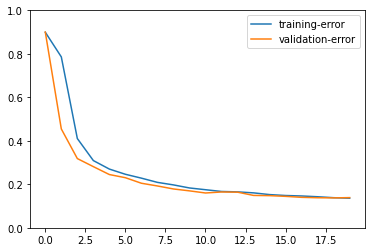

In [13]:
# Train and plot history:
fashion_net, _ = train(fashion_net, fashion_train_data, fashion_test_data, epochs, batch_size)

In [14]:
# Save Parameters:
fashion_net.save_parameters('fashion_net.params')

## Apply Updates and Retrain on the Fashion MNIST
We will now apply the following changes to the network and retrain after each update:
1.  Change average pooling to max pooling;
2. Change the filter size and number of channels of first 2 convolutional layers (conv layer1, conv layer2) to ([11 × 11/1, 32], [7 × 7/1, 16]), which means increasing kernel and number of channels. Add one more convolution layer of parameters [5×5/1, 16] with padding = 2.
3. Take the network obtained from (2) above, change activations of all 3 convolutional layers to ReLU.

### 1. Change average pooling to max pooling

In [15]:
f = 5 # filter size
s= 1 # stride length
p = same_conv_padding(f, s) #only one padding value since images are square (Length == Width)

fashion_net_improved = gluon.nn.HybridSequential()

with fashion_net_improved.name_scope():
    # First convolutional layer is a "same" convolution, rest are "valid" convolutions
    fashion_net_improved.add(nn.Conv2D(channels=6, kernel_size=f, strides=(s,s), padding=(p,p), activation='sigmoid'))
    fashion_net_improved.add(nn.MaxPool2D(pool_size=2, strides=2))            
    fashion_net_improved.add(nn.Conv2D(channels=16, kernel_size=f, strides=(s,s), padding=(0,0), activation='sigmoid'))
    fashion_net_improved.add(nn.MaxPool2D(pool_size=2, strides=2))
    fashion_net_improved.add(nn.Flatten())
    fashion_net_improved.add(nn.Dense(120, activation="sigmoid"))
    fashion_net_improved.add(nn.Dense(84, activation="sigmoid"))
    fashion_net_improved.add(nn.Dense(num_outputs))

[Epoch 0] train=0.098783 val=0.100000 time: 2.507926
[Epoch 1] train=0.098533 val=0.100000 time: 2.503326
[Epoch 2] train=0.103767 val=0.100000 time: 2.500296
[Epoch 3] train=0.397317 val=0.616900 time: 2.465210
[Epoch 4] train=0.672750 val=0.717900 time: 2.476434
[Epoch 5] train=0.727067 val=0.751200 time: 2.497985
[Epoch 6] train=0.760083 val=0.782800 time: 2.517047
[Epoch 7] train=0.784883 val=0.806200 time: 2.456245
[Epoch 8] train=0.807133 val=0.824100 time: 2.479239
[Epoch 9] train=0.825533 val=0.839100 time: 2.508077
[Epoch 10] train=0.836167 val=0.841700 time: 2.462103
[Epoch 11] train=0.844917 val=0.852600 time: 2.483768
[Epoch 12] train=0.851517 val=0.859000 time: 2.486008
[Epoch 13] train=0.857250 val=0.865600 time: 2.458053
[Epoch 14] train=0.861917 val=0.867000 time: 2.458067
[Epoch 15] train=0.866833 val=0.871200 time: 2.477521
[Epoch 16] train=0.869750 val=0.871000 time: 2.484024
[Epoch 17] train=0.872267 val=0.871700 time: 2.458562
[Epoch 18] train=0.876467 val=0.881200

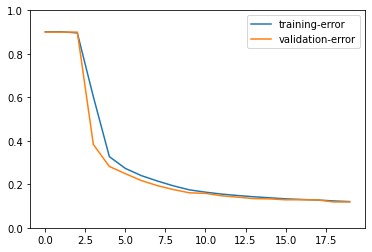

In [16]:
# Evaluate the newly improved net
initialize(fashion_net_improved)
fashion_net_improved, _ = train(fashion_net_improved, fashion_train_data, fashion_test_data, epochs, batch_size)

### 2. Change the filter size and number of channels of first 2 convolutional layers
Change the filter size and number of channels of first 2 convolutional layers (conv layer1, conv layer2) to ([11 × 11/1, 32], [7 × 7/1, 16]), which means increasing kernel and number of channels. Add one more convolution layer of parameters [5×5/1, 16] with padding = 2.

In [17]:
num_outputs = 10 # 10 Different classes of clothing

# New filter sizes for each convolutional layer:
f1 = 11
f2 = 7
f3 = 5

s= 1 # stride length

# Same convolution padding used for the first convolutional layer
p = same_conv_padding(f1, s) # only one padding value since images are square (Length == Width)

fashion_net_improved = gluon.nn.HybridSequential()

with fashion_net_improved.name_scope():
    
    # First convolutional layer is a "same" convolution, rest are "valid" convolutions
    fashion_net_improved.add(nn.Conv2D(channels=32, kernel_size=f1, strides=(s,s), padding=(p,p), activation='sigmoid'))
    fashion_net_improved.add(nn.MaxPool2D(pool_size=2, strides=2))            
    fashion_net_improved.add(nn.Conv2D(channels=16, kernel_size=f2, strides=(s,s), padding=(0,0), activation='sigmoid'))
    fashion_net_improved.add(nn.MaxPool2D(pool_size=2, strides=2))
    fashion_net_improved.add(nn.Conv2D(channels=16, kernel_size=f3, strides=(s,s), padding=(2,2), activation='sigmoid'))
    fashion_net_improved.add(nn.MaxPool2D(pool_size=2, strides=2))    
    fashion_net_improved.add(nn.Flatten())
    fashion_net_improved.add(nn.Dense(120, activation="sigmoid"))
    fashion_net_improved.add(nn.Dense(84, activation="sigmoid"))
    fashion_net_improved.add(nn.Dense(num_outputs))

[Epoch 0] train=0.099767 val=0.100000 time: 2.634006
[Epoch 1] train=0.101817 val=0.100000 time: 2.457772
[Epoch 2] train=0.100100 val=0.100000 time: 2.473773
[Epoch 3] train=0.099600 val=0.100000 time: 2.511427
[Epoch 4] train=0.101800 val=0.100000 time: 2.503194
[Epoch 5] train=0.098917 val=0.100000 time: 2.503458
[Epoch 6] train=0.099317 val=0.100000 time: 2.506196
[Epoch 7] train=0.100200 val=0.100000 time: 2.570551
[Epoch 8] train=0.098600 val=0.100000 time: 2.459863
[Epoch 9] train=0.100167 val=0.100000 time: 2.535505
[Epoch 10] train=0.102950 val=0.100000 time: 2.490240
[Epoch 11] train=0.128283 val=0.193800 time: 2.476687
[Epoch 12] train=0.241983 val=0.295000 time: 2.539909
[Epoch 13] train=0.417567 val=0.521900 time: 2.473238
[Epoch 14] train=0.593350 val=0.694800 time: 2.502349
[Epoch 15] train=0.680900 val=0.694900 time: 2.490539
[Epoch 16] train=0.715367 val=0.732000 time: 2.514866
[Epoch 17] train=0.732400 val=0.742800 time: 2.498212
[Epoch 18] train=0.751817 val=0.762400

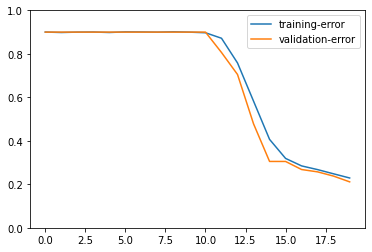

In [18]:
batch_size = 255
initialize(fashion_net_improved)
fashion_net_improved, _ = train(fashion_net_improved, fashion_train_data, fashion_test_data, epochs, batch_size)

3. Take the network obtained from (2) above, change activations of all 3 convolutional layers to ReLU.

In [19]:
num_outputs = 10 # 10 Different classes of clothing

f1 = 11 # filter size
f2 = 7
f3 = 5
s= 1 # stride length
p = same_conv_padding(f1, s) #only one padding value since images are square (Length == Width)

fashion_net_improved = gluon.nn.HybridSequential()

with fashion_net_improved.name_scope():
    
    # First convolutional layer is a "same" convolution, rest are "valid" convolutions
    fashion_net_improved.add(nn.Conv2D(channels=32, kernel_size=f1, strides=(s,s), padding=(p,p), activation='relu'))
    fashion_net_improved.add(nn.MaxPool2D(pool_size=2, strides=2))            
    fashion_net_improved.add(nn.Conv2D(channels=16, kernel_size=f2, strides=(s,s), padding=(0,0), activation='relu'))
    fashion_net_improved.add(nn.MaxPool2D(pool_size=2, strides=2))
    fashion_net_improved.add(nn.Conv2D(channels=16, kernel_size=f3, strides=(s,s), padding=(2,2), activation='relu'))
    fashion_net_improved.add(nn.MaxPool2D(pool_size=2, strides=2))    
    fashion_net_improved.add(nn.Flatten())
    fashion_net_improved.add(nn.Dense(120, activation="sigmoid"))
    fashion_net_improved.add(nn.Dense(84, activation="sigmoid"))
    fashion_net_improved.add(nn.Dense(num_outputs))

[Epoch 0] train=0.434433 val=0.721100 time: 2.472293
[Epoch 1] train=0.752283 val=0.819600 time: 2.495614
[Epoch 2] train=0.821250 val=0.850500 time: 2.464797
[Epoch 3] train=0.847417 val=0.863900 time: 2.526258
[Epoch 4] train=0.862850 val=0.871000 time: 2.507557
[Epoch 5] train=0.874117 val=0.878300 time: 2.474132
[Epoch 6] train=0.880633 val=0.884500 time: 2.497164
[Epoch 7] train=0.885117 val=0.883400 time: 2.475035
[Epoch 8] train=0.893350 val=0.887100 time: 2.469704
[Epoch 9] train=0.896733 val=0.883700 time: 2.498565
[Epoch 10] train=0.898717 val=0.889200 time: 2.563375
[Epoch 11] train=0.901133 val=0.893300 time: 2.509242
[Epoch 12] train=0.905400 val=0.894000 time: 2.486483
[Epoch 13] train=0.909300 val=0.895300 time: 2.514732
[Epoch 14] train=0.910200 val=0.897300 time: 2.490899
[Epoch 15] train=0.912833 val=0.898700 time: 2.478054
[Epoch 16] train=0.913717 val=0.896400 time: 2.466483
[Epoch 17] train=0.917550 val=0.900900 time: 2.487839
[Epoch 18] train=0.919783 val=0.897600

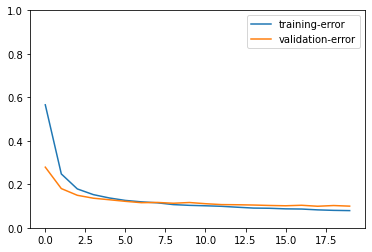

In [20]:
initialize(fashion_net_improved)
fashion_net_improved, evals2 = train(fashion_net_improved, fashion_train_data, fashion_test_data, epochs, batch_size)

In [21]:
fashion_net_improved.save_parameters('fashion_net_improved.params')

## Question 2: Cats vs Dogs Classifier
In this question you train a neural network of your choice to solve the binary classification problem of “Cats vs Dogs” dataset. The training and validation datasets can be obtained from this link. The TA will test your network on a test dataset not available to you.
1. Start with the architecture introduced in figure 1 of Q1. Change the number of classes in the output Fully Connected Layer to 2.
2. Use data augmentation mentioned in tutorial 6 with fine-tuning of MNIC-2500 dataset. Specifically, For the training dataset
 - Randomly resize and crop to 224 × 224;
 - Randomly flip horizontally (left-right);
 - Randomly jitter color with all parameters equal to 0.4;
 - Randomly change lightning with parameter equal to 0.1;
 - Change to tensor;
 - Data normalization: Remove the mean [0.485, 0.456, 0.406], and divide by the standard deviation [0.229, 0.224, 0.225];
3. For the validation dataset:
 - Resize to 256;
 - Crop center part of the resized image with crop size 224 × 224;
 - Change to tensor;
 - Normalize as for training dataset;
3. Train on the default parameters for epochs=20, batch size=128. Show the training progress by calling the function plot history(evals, epoch) after each epoch.
4. Download the pretrained AlexNet model, and fine-tune it for 10 epochs. Show the training progress by calling the function plot history(evals, epoch) after each epoch. Experiment with changing the learning rate lr and learning decay factor lr decay to smaller values. Describe what you observe.

In [41]:
num_outputs = 2 # Cats vs. Dogs

cat_dog_net = gluon.nn.HybridSequential()

with cat_dog_net.name_scope():
    
    # First convolutional layer is a "same" convolution, rest are "valid" convolutions
    cat_dog_net.add(nn.Conv2D(channels=32, kernel_size=f1, strides=(s,s), padding=(p,p), activation='relu'))
    cat_dog_net.add(nn.MaxPool2D(pool_size=2, strides=2))            
    cat_dog_net.add(nn.Conv2D(channels=16, kernel_size=f2, strides=(s,s), padding=(0,0), activation='relu'))
    cat_dog_net.add(nn.MaxPool2D(pool_size=2, strides=2))
    cat_dog_net.add(nn.Conv2D(channels=16, kernel_size=f3, strides=(s,s), padding=(2,2), activation='relu'))
    cat_dog_net.add(nn.MaxPool2D(pool_size=2, strides=2))    
    cat_dog_net.add(nn.Flatten())
    cat_dog_net.add(nn.Dense(120, activation="sigmoid"))
    cat_dog_net.add(nn.Dense(84, activation="sigmoid"))
    cat_dog_net.add(nn.Dense(num_outputs))

### Data Augmentation:
Here, we have a function to transform and augment our cat and dog images

In [39]:
jitter_param = 0.4
lighting_param = 0.1
    
transform_train = transforms.Compose([
    
    # Randomly resize and crop to 224 × 224;
    transforms.Resize(224),
    gcv_transforms.RandomCrop(224, pad=4),
    
    # Randomly flip horizontally (left-right);
    transforms.RandomFlipLeftRight(),
    
    # Randomly jitter color with all parameters equal to 0.4;
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param, saturation=jitter_param),
    
    # Randomly change lightning with parameter equal to 0.1;
    transforms.RandomLighting(lighting_param),
    
    # Change to tensor;
    transforms.ToTensor(),
    
    # Data normalization: Remove the mean [0.485, 0.456, 0.406], and divide by the 
    # standard deviation [0.229, 0.224, 0.225];
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Load Data:
Use the ImageFolderDataset tool to pack cat and dog images into DataLoaders

In [40]:
# If not already done, download the train_data_cats_vs_dogs dataset from Google Drive and
# unzip it in the current directory.
train_path = './train_data_cats_vs_dogs/train'
val_path = './train_data_cats_vs_dogs/valid'

# train_dataset = gluon.data.vision.datasets.ImageFolderDataset(train_path).transform_first(transform_train)
# val_dataset = gluon.data.vision.datasets.ImageFolderDataset(val_path).transform_first(transform_test)

train_dataset = gluon.data.vision.datasets.ImageFolderDataset(train_path).transform_first(transform_train)
val_dataset = gluon.data.vision.datasets.ImageFolderDataset(val_path).transform_first(transform_test)

# train_dataset = gluon.data.vision.datasets.FashionMNIST(train=True, transform=transform)
# val_dataset = gluon.data.vision.datasets.FashionMNIST(train=False, transform=transform)

animals_train_data = gluon.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers = 8)

animals_val_data = gluon.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers = 8)

/root/miniconda3/lib/python3.8/site-packages/mxnet/gluon/data/vision/datasets.py:317: UserWarning: Ignoring ./train_data_cats_vs_dogs/train/cat/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  warnings.warn('Ignoring %s of type %s. Only support %s'%(
/root/miniconda3/lib/python3.8/site-packages/mxnet/gluon/data/vision/datasets.py:317: UserWarning: Ignoring ./train_data_cats_vs_dogs/train/dog/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  warnings.warn('Ignoring %s of type %s. Only support %s'%(


### Initialize and Train

In [42]:
initialize(cat_dog_net)

[Epoch 0] train=0.500569 val=0.500000 time: 14.381651
[Epoch 1] train=0.499004 val=0.500000 time: 14.304660
[Epoch 2] train=0.504622 val=0.500000 time: 14.331387
[Epoch 3] train=0.496160 val=0.500000 time: 14.369072
[Epoch 4] train=0.498293 val=0.500000 time: 14.364348
[Epoch 5] train=0.504694 val=0.500000 time: 14.364140
[Epoch 6] train=0.500071 val=0.500000 time: 14.407812
[Epoch 7] train=0.491751 val=0.500000 time: 14.394231
[Epoch 8] train=0.496729 val=0.500000 time: 14.378292
[Epoch 9] train=0.501067 val=0.500000 time: 14.431729


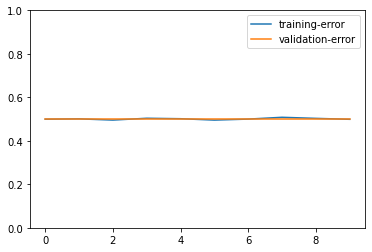

In [43]:
cat_dog_net, evals2 = train(cat_dog_net, animals_train_data, animals_val_data, epochs, batch_size)

### 5. Download the pretrained AlexNet model, and fine-tune it for 10 epochs.

In [29]:
from gluoncv.model_zoo import get_model

In [30]:
pre_alexnet = get_model('alexnet', pretrained=True)
with pre_alexnet.name_scope():
    pre_alexnet.output = nn.Dense(num_outputs)
    
pre_alexnet.output.initialize(mx.init.Xavier(magnitude=2.24), ctx = ctx)
pre_alexnet.collect_params().reset_ctx(ctx)

221999KB [00:06, 32443.57KB/s]                            


In [31]:
pre_alexnet.hybridize()

In [32]:
batch_size = 60
epochs = 10
lr_decay = 0.1
lr = 0.9 # Learning rate
lr_decay_epoch = [4, 8, np.inf]

[Epoch 0] train=0.502418 val=0.500000 time: 12.563563
[Epoch 1] train=0.500000 val=0.500000 time: 12.095567
[Epoch 2] train=0.500000 val=0.500000 time: 12.115211
[Epoch 3] train=0.500000 val=0.500000 time: 12.016625
[Epoch 4] train=0.500000 val=0.500000 time: 12.152913
[Epoch 5] train=0.500000 val=0.500000 time: 11.943907
[Epoch 6] train=0.500000 val=0.500000 time: 12.155550
[Epoch 7] train=0.500000 val=0.500000 time: 12.118011
[Epoch 8] train=0.500000 val=0.500000 time: 12.049749
[Epoch 9] train=0.500000 val=0.500000 time: 12.123805


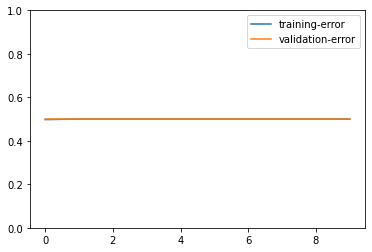

In [33]:
pre_alexnet, _ = train(pre_alexnet, animals_train_data, animals_val_data, 
                       epochs, batch_size, lr, lr_decay, lr_decay_epoch)